# Hamming distance histograms

Local and global Hamming distance superimposed. 
- Local: the surface of the neutral space 
- Global: the total genotypes in the map

No deleterious ignores the gneotypes of phenotype '.'*L

In [2]:
import pickle 
with open("../data/hammingglobalDPD_nodel.pkl","rb") as f:
    hammingglobalDPD = pickle.load(f)
with open("../data/hamminglocalDPD_nodel.pkl","rb") as f:
    hamminglocalDPD = pickle.load(f)
with open("../data/edgeD.pkl","rb") as f:
    edgeD = pickle.load(f)
with open("../data/neutralsets.pkl","rb") as f:
    neutralsets = pickle.load(f)
L=12
K=4

In [3]:
from collections import defaultdict
sort_neutralsets = defaultdict(float)
sorted_neutralsets = dict(sorted(neutralsets.items(), key=lambda item: item[1], reverse=True))
for k, v in sorted_neutralsets.items():
    k = k.replace('\n', '')
    sort_neutralsets[k] = v

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


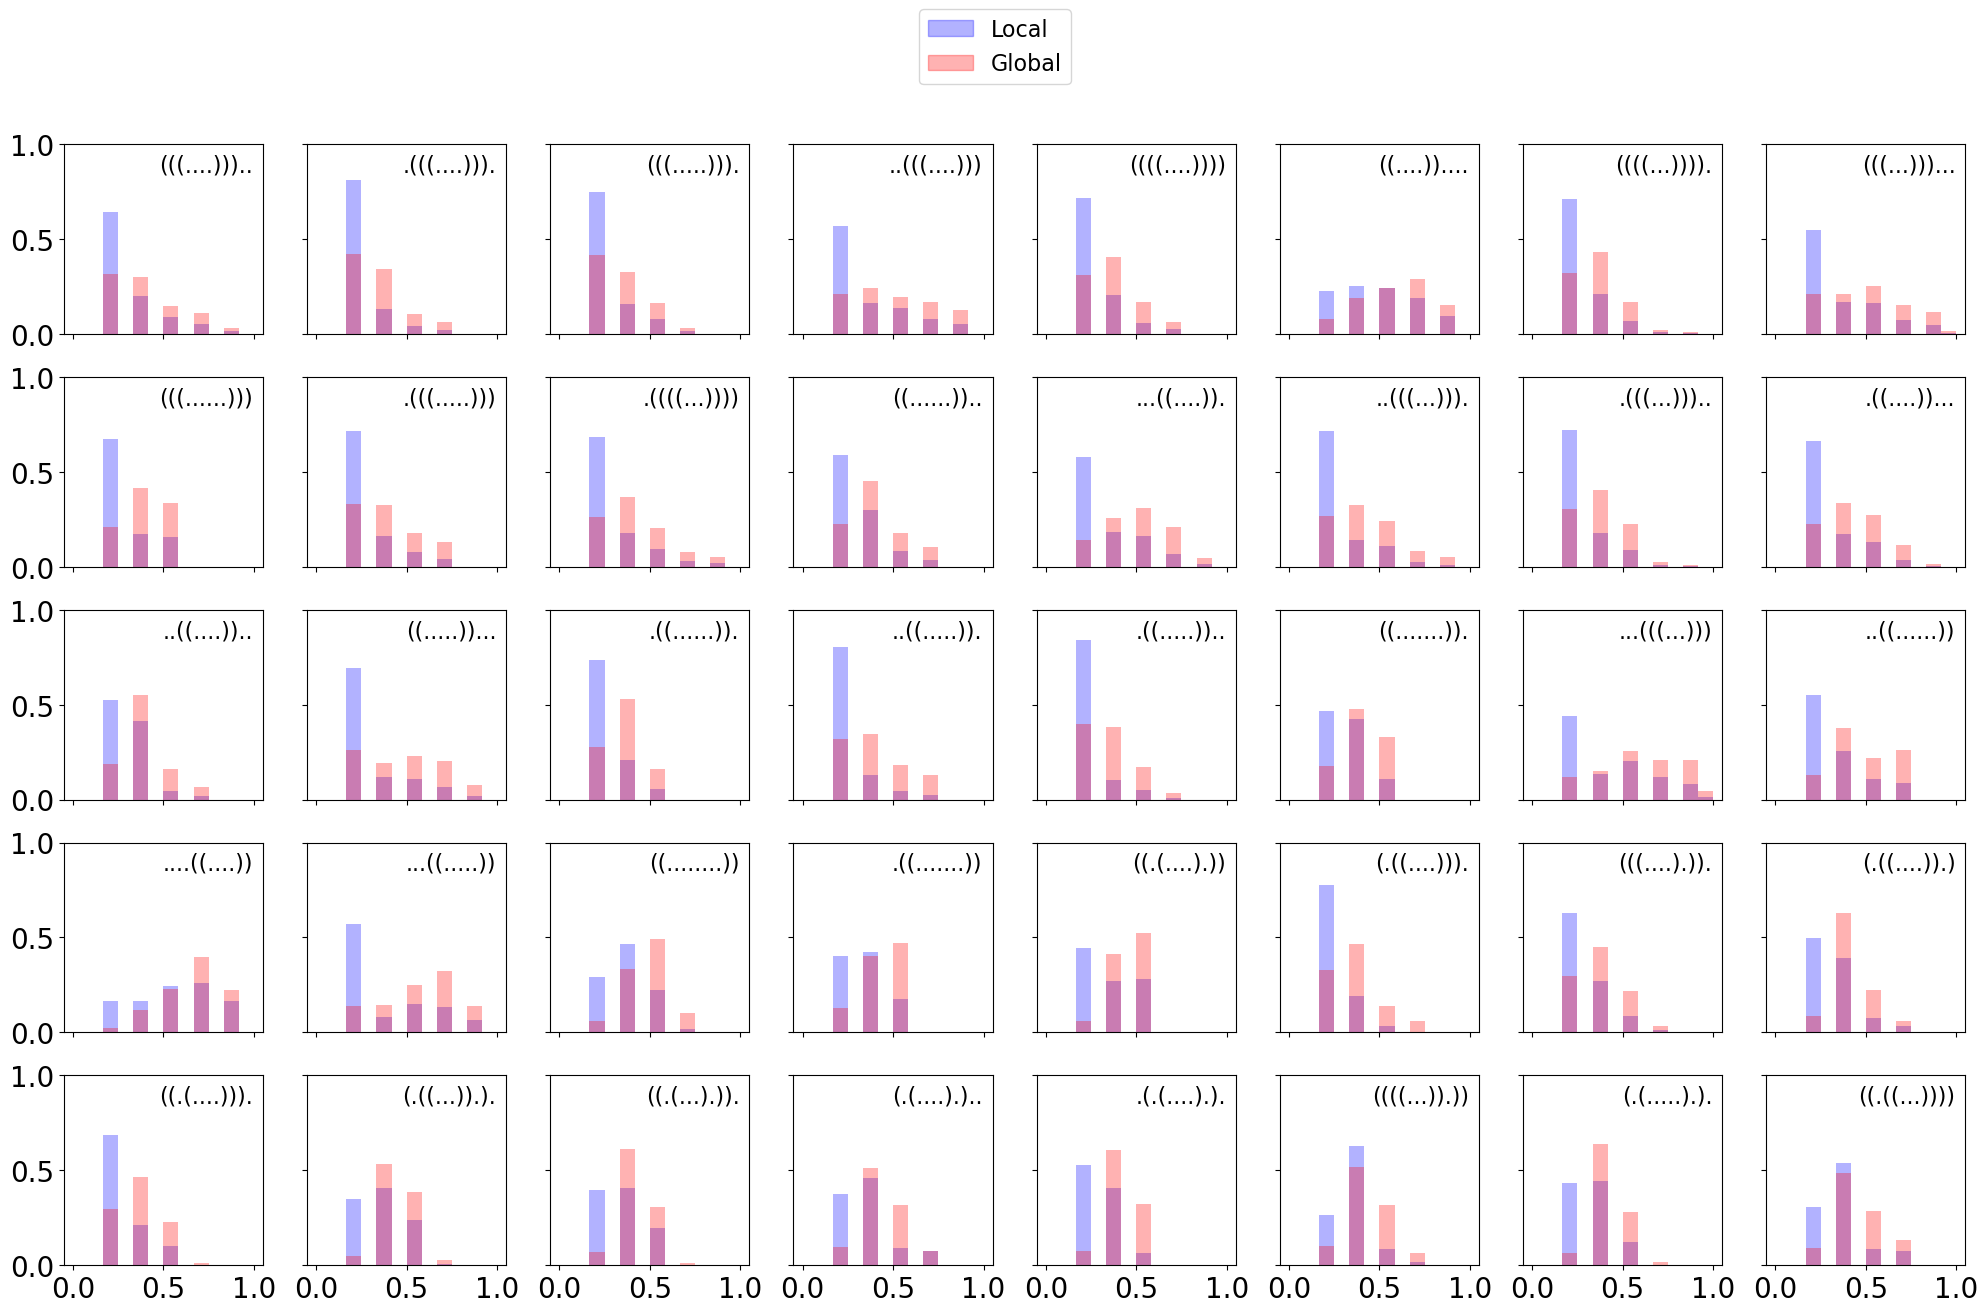

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

fig, axs = plt.subplots(5, 8, figsize=(20, 12), sharex=True, sharey=True)  # 5 rows, 8 columns

bins = np.linspace(0, 1, L+1)


for i, ax in enumerate(axs.flatten()):
    if i < len(hamminglocalDPD):
        key = list(sort_neutralsets.keys())[i+1]

        h_values = list(hamminglocalDPD[key].keys())
        counts = list(hamminglocalDPD[key].values())
        
        ax.hist(h_values, bins=bins, weights=np.array(counts)/(edgeD[key]), color='blue', alpha=0.3)
        
        h_values1 = list(hammingglobalDPD[key].keys())
        counts1 = np.array(list(hammingglobalDPD[key].values()))/np.sum(list(sort_neutralsets.values())[1:])
        
        ax.hist(h_values1, bins=bins, weights=np.array(counts1), color='red', alpha=0.3)
        
        ax.text(0.95, 0.95, key, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=16)
        ax.set_yticks([0.0,0.5,1.0])
        ax.set_xticks([0.0,0.5,1.0])
        ax.tick_params(axis='both', which='major', labelsize=20)  # Set tick label size


blue_patch = mpatches.Patch(color='blue', alpha=0.3, label='Local')
red_patch = mpatches.Patch(color='red', alpha=0.3, label='Global')
fig.legend(handles=[blue_patch, red_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=16)
plt.tight_layout()
plt.savefig("hamming.png", bbox_inches='tight')
plt.show()

# $\phi_{pq}$ with Hamming distance

The $\phi_{pq}$ is the probability of phenotype $q$ mutating to a phenoytpe $p$:

$\sum_p \phi_{pq}$ = 1 

We check that probabilities are higher for similar phenotypes.

Colormap divides warm to cool, with cool colours corresponding to similar phenotypes (low $H$) and  warm colours to less similar (high $H$), normalised from 0-1 with $H-0.5$ as the midpoint for the normalised colormap.

We skip the deleterious and the neutral set.

In [2]:
import pickle
with open("../data/phipq.pkl","rb") as f:
    phipq = pickle.load(f)

L=12
K=4

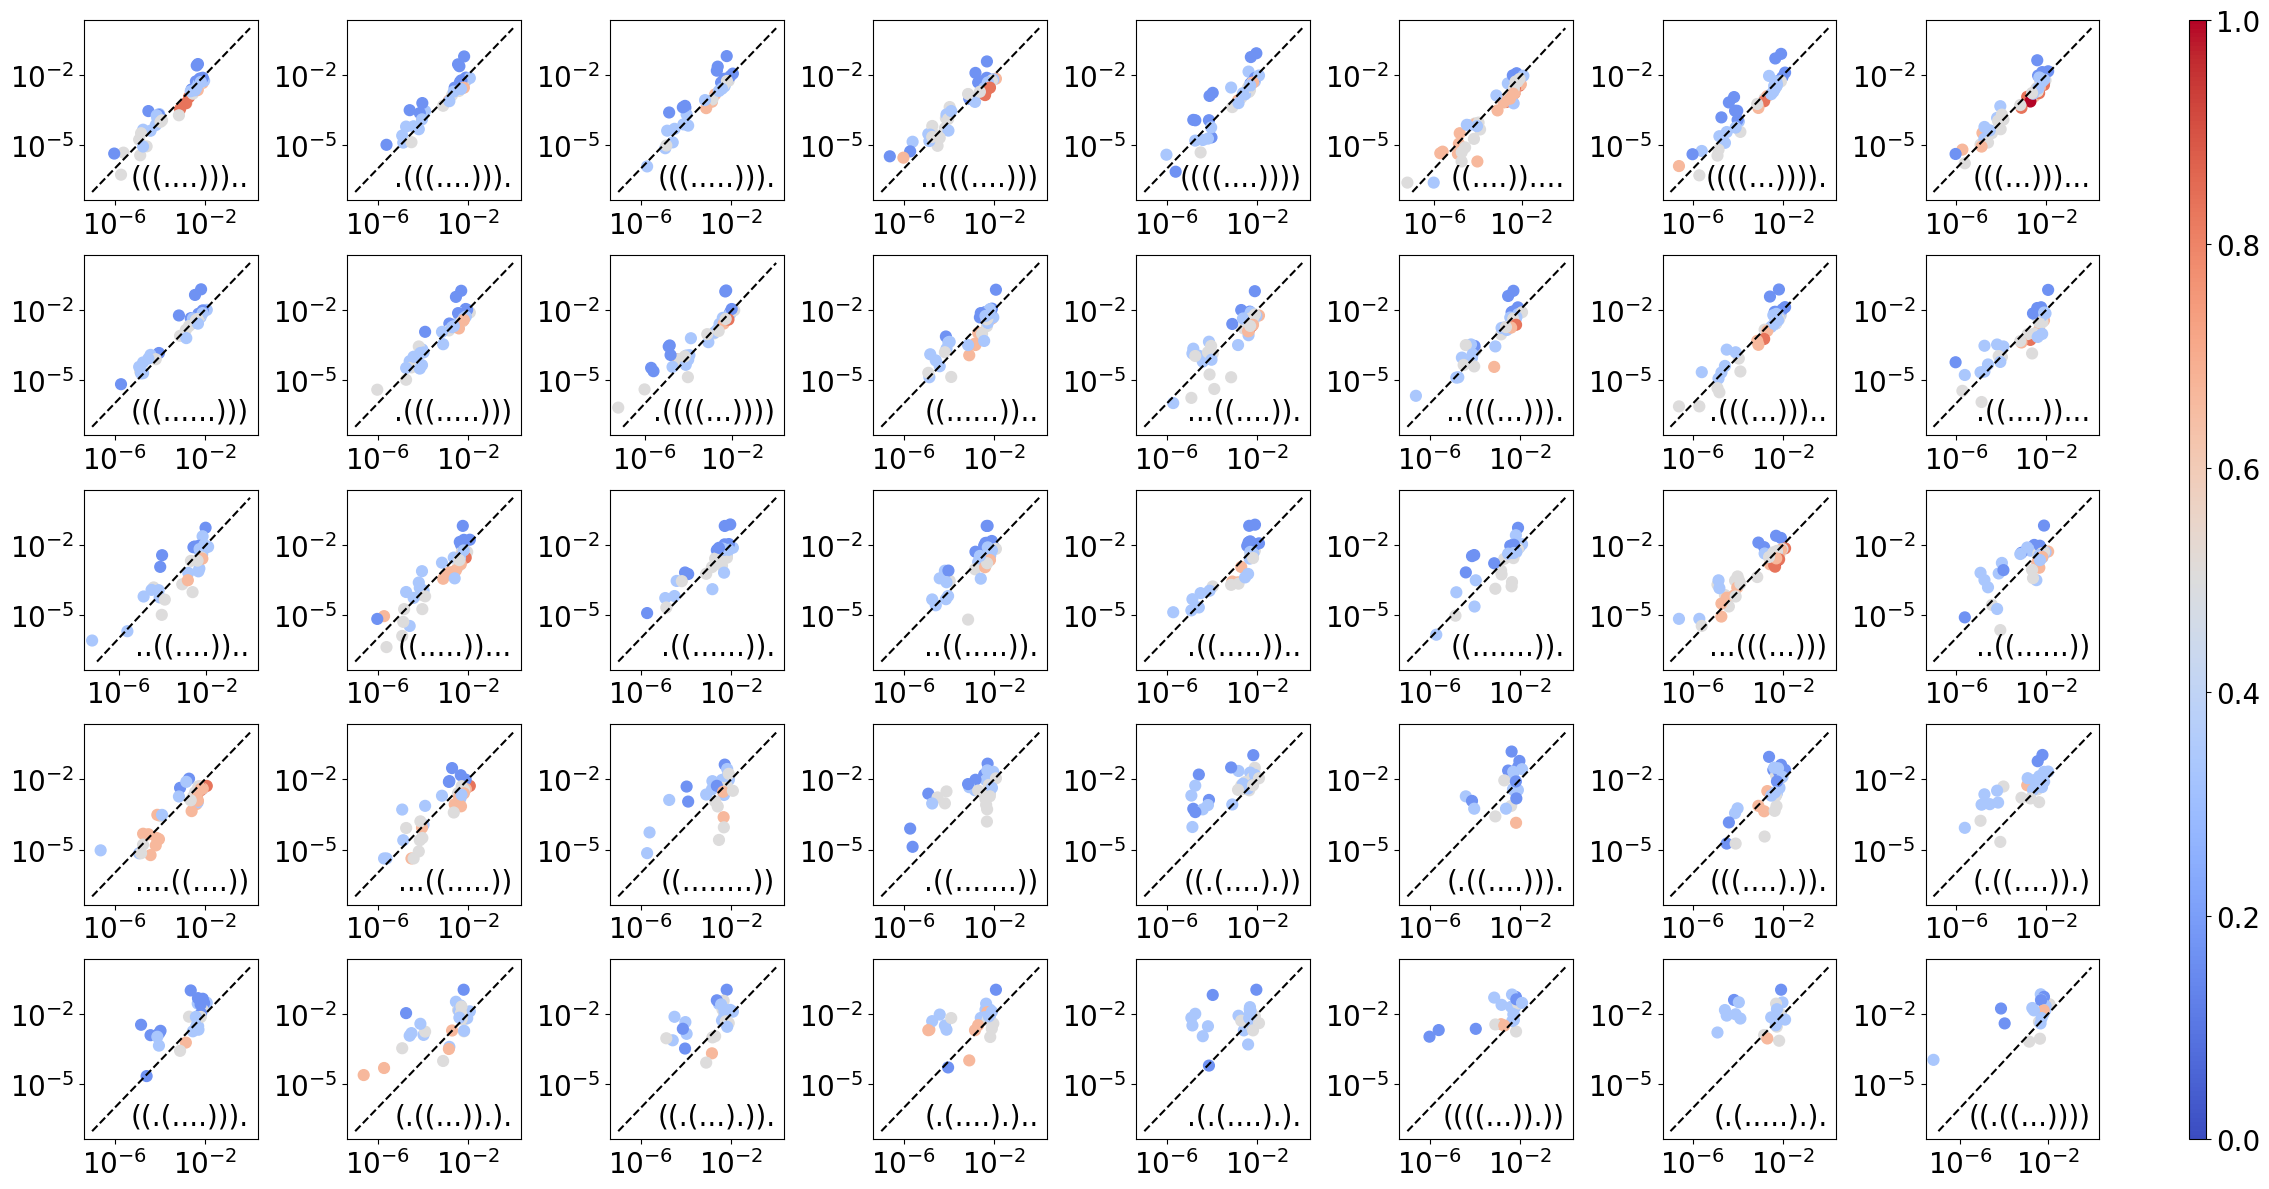

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import sys
from matplotlib.gridspec import GridSpec
sys.path.append('/home/pg520/phenodistance')
from main.functions.structurefunctions import hamming

class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0.5, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Normalize the values
        result, is_scalar = self.process_value(value)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        # Shift the values to the range [0, 1]
        result = np.ma.masked_array((result - vmin) / (vmax - vmin))
        result = np.ma.masked_array(np.interp(result, [0, midpoint, 1], [0, 0.5, 1]))

        if is_scalar:
            result = result[0]
        return result

# Create a grid layout with space for the colorbar
fig = plt.figure(figsize=(24, 12))
gs = GridSpec(5, 9, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 0.1])

plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 5
cmap = plt.get_cmap('coolwarm')  # Get the colormap
norm = MidpointNormalize(vmin=0, vmax=1, midpoint=0.5)  # Use custom normalization

axs = [fig.add_subplot(gs[i, j]) for i in range(5) for j in range(8)]

for i, ax in enumerate(axs):
    if i < len(phipq):
        key = list(sort_neutralsets.keys())[i+1]
        qitems = phipq[key]
        listphipq = []
        listhamming = []
        listfreq = []
        
        for q, phi in qitems.items():
            if q == '.'*L or q == key:  # Skip the neutral set and the del sequence
                continue
            listphipq.append(phi)
            listhamming.append(hamming(key, q))
            listfreq.append(neutralsets[q+'\n'] / K**L)
        
        scatter = ax.scatter(listfreq, listphipq, s=60, c=listhamming, cmap=cmap, norm=norm, alpha=1)  # Use the colormap to determine the color

        ax.plot([1e-7, 1], [1e-7, 1], color='black', linestyle='--')
        ax.set_xscale("log")
        ax.set_yscale('log')
        ax.set_xticks([1e-6, 1e-2])
        ax.text(0.95, 0.05, key, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)  # Set tick label size

# Add a colorbar for the entire figure on the side
cbar_ax = fig.add_subplot(gs[:, -1])  # Create an axis for the colorbar
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
cbar.set_label('')
cbar.ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to make space for the colorbar
plt.savefig("phipq.png", bbox_inches='tight')
plt.show()

Ranking of the distance to diagonal to check which stuctures are the most probable. These are indeed the ones that have one less or one more base pair close to the original base pairs

/tmp/ipykernel_1117534/1366763604.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar


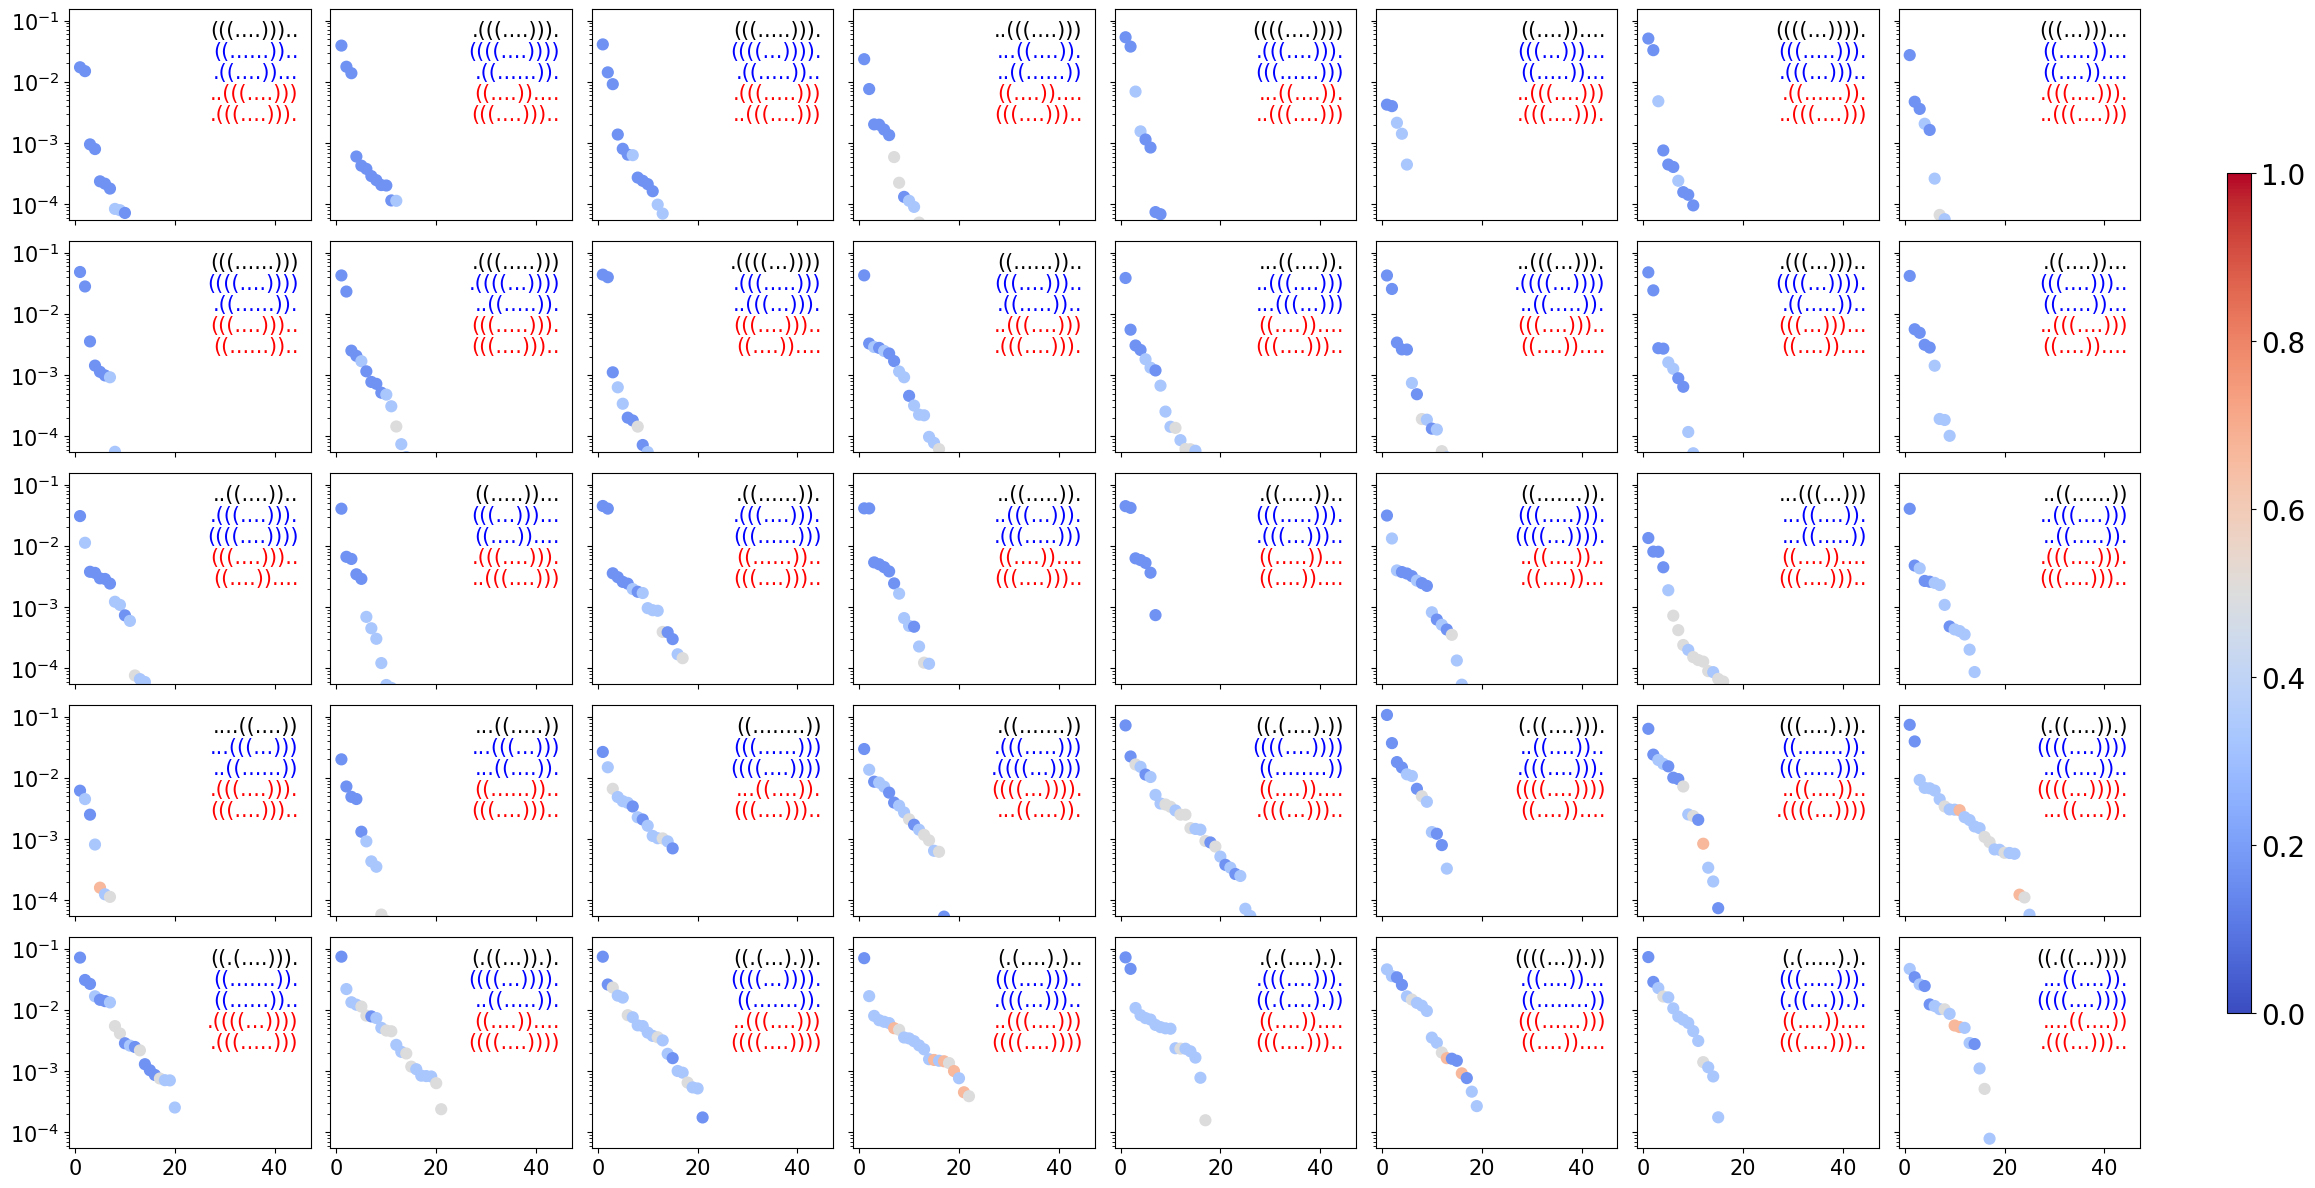

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import sys
from matplotlib.gridspec import GridSpec
sys.path.append('/home/pg520/phenodistance')
from main.functions.structurefunctions import hamming

class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0.5, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Normalize the values
        result, is_scalar = self.process_value(value)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        # Shift the values to the range [0, 1]
        result = np.ma.masked_array((result - vmin) / (vmax - vmin))
        result = np.ma.masked_array(np.interp(result, [0, midpoint, 1], [0, 0.5, 1]))

        if is_scalar:
            result = result[0]
        return result

# Create a grid layout with space for the colorbar
fig, axs = plt.subplots(5, 8, figsize=(24, 12), sharex=True, sharey=True)
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 5
cmap = plt.get_cmap('coolwarm')  # Get the colormap
norm = MidpointNormalize(vmin=0, vmax=1, midpoint=0.5)  # Use custom normalization

for i, ax in enumerate(axs.flatten()):
    if i < len(phipq):
        key = list(sort_neutralsets.keys())[i+1]
        qitems = phipq[key]
        listphipq = []
        listfreq = []
        distances = []
        listhamming = []
        phenos = []

        for q, phi in qitems.items():
            if q == '.'*L or q == key:  # Skip the neutral set and the del sequence
                continue
            listphipq.append(phi)
            listfreq.append(neutralsets[q+'\n'] / K**L)
            listhamming.append(hamming(key, q))
            # Calculate the distance from the point to the diagonal y = x
            distance = (phi - (neutralsets[q+'\n'] / K**L)) / np.sqrt(2)
            distances.append(distance)
            phenos.append(q)
        
        # Get the sorted indices of distances in descending order
        sorted_indices = np.argsort(distances)[::-1]
        
        # Sort distances and listhamming based on the sorted indices
        ranked_distances = np.array(distances)[sorted_indices]
        sorted_listhamming = np.array(listhamming)[sorted_indices]
        sorted_phenos = np.array(phenos)[sorted_indices]
        
        # Plot the distance versus its ranking
        scatter = ax.scatter(np.arange(1, len(ranked_distances)+1), ranked_distances, s=60, c=sorted_listhamming, cmap=cmap, norm=norm, alpha=1)
        ax.set_yscale('log')
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.text(0.95, 0.95, key, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=15)
        for j in range(1,3):
            ax.text(0.95, 0.95-0.1*j, f"{sorted_phenos[j-1]}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=15, color = 'blue')
        for k in range(1,3):
            ax.text(0.95, 0.95-0.1*j-0.1*k, f"{sorted_phenos[-2:][k-1]}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=15, color = 'red')
# Set common labels
#fig.text(0.5, 0.04, 'Ranking', ha='center', fontsize=20)
#fig.text(0.04, 0.5, 'Distance', va='center', rotation='vertical', fontsize=20)

# Add a colorbar for the entire figure on the side
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])  # Move to the right and make thinner
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
cbar.set_label('')
cbar.ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar
plt.savefig("distance_ranking.png", bbox_inches='tight')
plt.show()

# Neutral correlations

In [12]:
with open("../data/rhopDPD.pkl","rb") as f:
    rhopDPD = pickle.load(f)
with open("../data/rhopMFE.pkl","rb") as f:
    rhopD= pickle.load(f)
with open("../data/neutralsetsDPD.pkl","rb") as f:
    neutralsetsDPD= pickle.load(f)

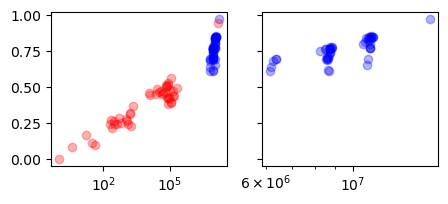

In [37]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(5,2), sharey=True)
ax[0].scatter(list(neutralsetsDPD.values()),list(rhopDPD.values()),color='blue',alpha=0.3)
ax[0].scatter(list(neutralsets.values()),list(rhopD.values()),color='red',alpha=0.3)
ax[0].set_xscale('log')

ax[1].scatter(list(neutralsetsDPD.values()),list(rhopDPD.values()),color='blue',alpha=0.3)
ax[1].set_xscale('log')

# Site quantities

Take the each site and calculate average Hamming distance (local and global) from each mutation on it in the neutral set.

In [ ]:
import pickle
with open("../data/hamming_local_D_PD_site.pkl","rb") as f:
    hamming_local_site = pickle.load(f)
with open("../data/edge_hamming_local_D_PD_site.pkl","rb") as f:
    edgeD = pickle.load(f) #includes deleterious


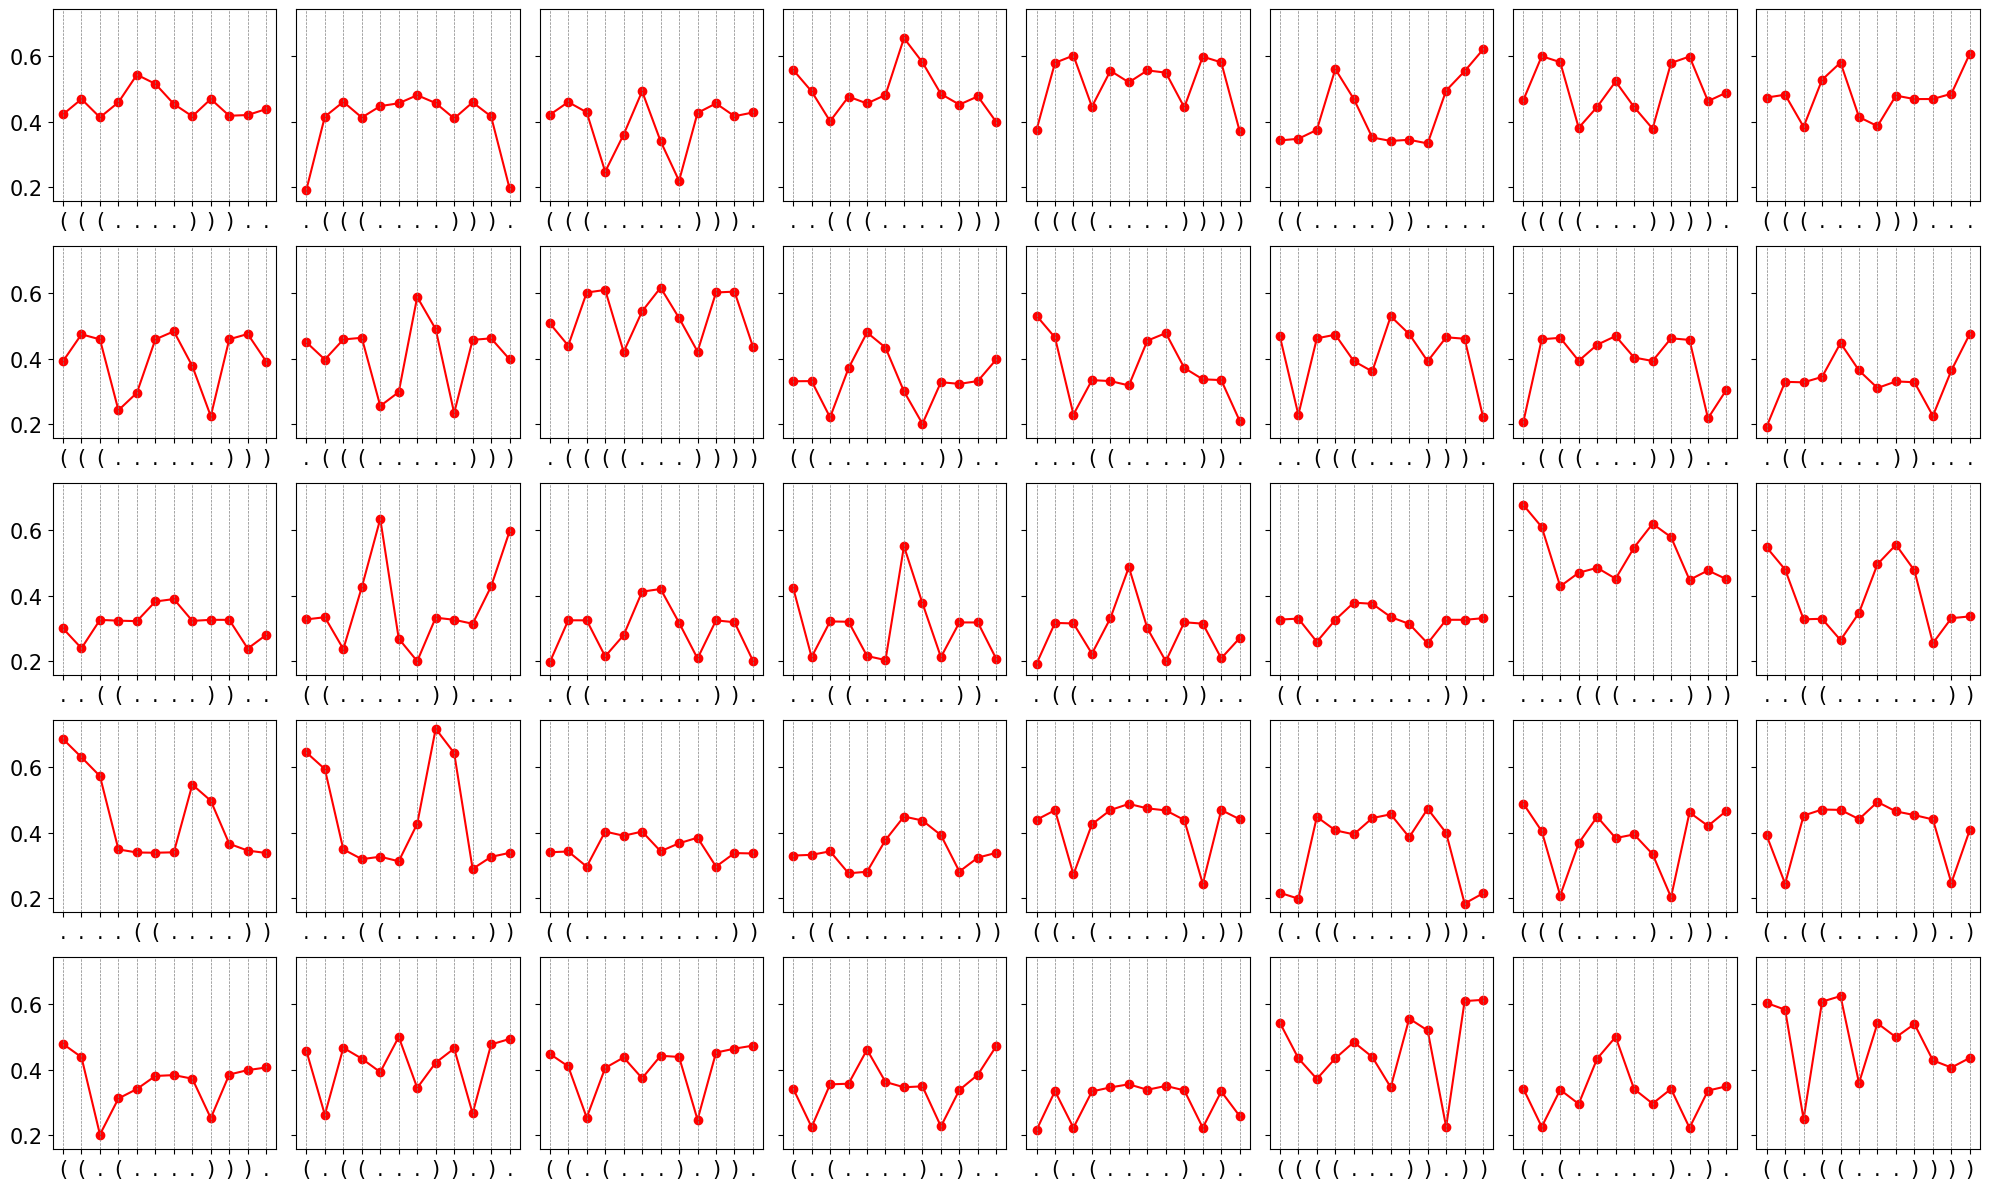

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

fig, axs = plt.subplots(5, 8, figsize=(20, 12), sharey=True)  # 5 rows, 8 columns
L = 12
sites_pos = np.arange(1, L + 1, 1)

for i, ax in enumerate(axs.flatten()):
    if i < len(hamming_local_site):
        key = list(sort_neutralsets.keys())[i + 1]
        sites = [0] * L

        for site, avgs in hamming_local_site[key].items():
            sites[site] = avgs / edgeD[key][site]
        ax.plot(sites_pos, np.array(sites), '-o', color='red')

        # Add vertical dashed lines at each x position
        for pos in sites_pos:
            ax.axvline(x=pos, color='gray', linestyle='--', linewidth=0.5)

        #ax.text(0.95, 0.95, key, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=16)
        ax.set_xticks(sites_pos)  # Set x-ticks to the positions of the sites
        ax.set_xticklabels([key[i] for i in range(L)])  # Label the x-ticks with the corresponding key sites
        ax.tick_params(axis='both', which='major', labelsize=15)  # Set tick label size

#red_patch = mpatches.Patch(color='red', label='Local')
#fig.legend(handles=[red_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=16)
plt.tight_layout()
plt.savefig("hamming_site.png", bbox_inches='tight')
plt.show()

# Diversity of site local mutants

check in each site how diverse is the dsitribution of the phenotypes.

In [32]:
import pickle

with open("../data/phenos_site.pkl","rb") as f:
    phenos_site = pickle.load(f)

In [37]:
from collections import Counter
from collections import defaultdict
import functools
phenos_site_set = defaultdict(functools.partial(defaultdict, list))
for pheno,phenos in phenos_site.items():
    for site, site_phenos in phenos.items():
        phenos_site_set[pheno][site] = dict(Counter(site_phenos))
        for phenodict, countphenos in phenos_site_set[pheno][site].items():
            phenos_site_set[pheno][site][phenodict] = countphenos/len(site_phenos)

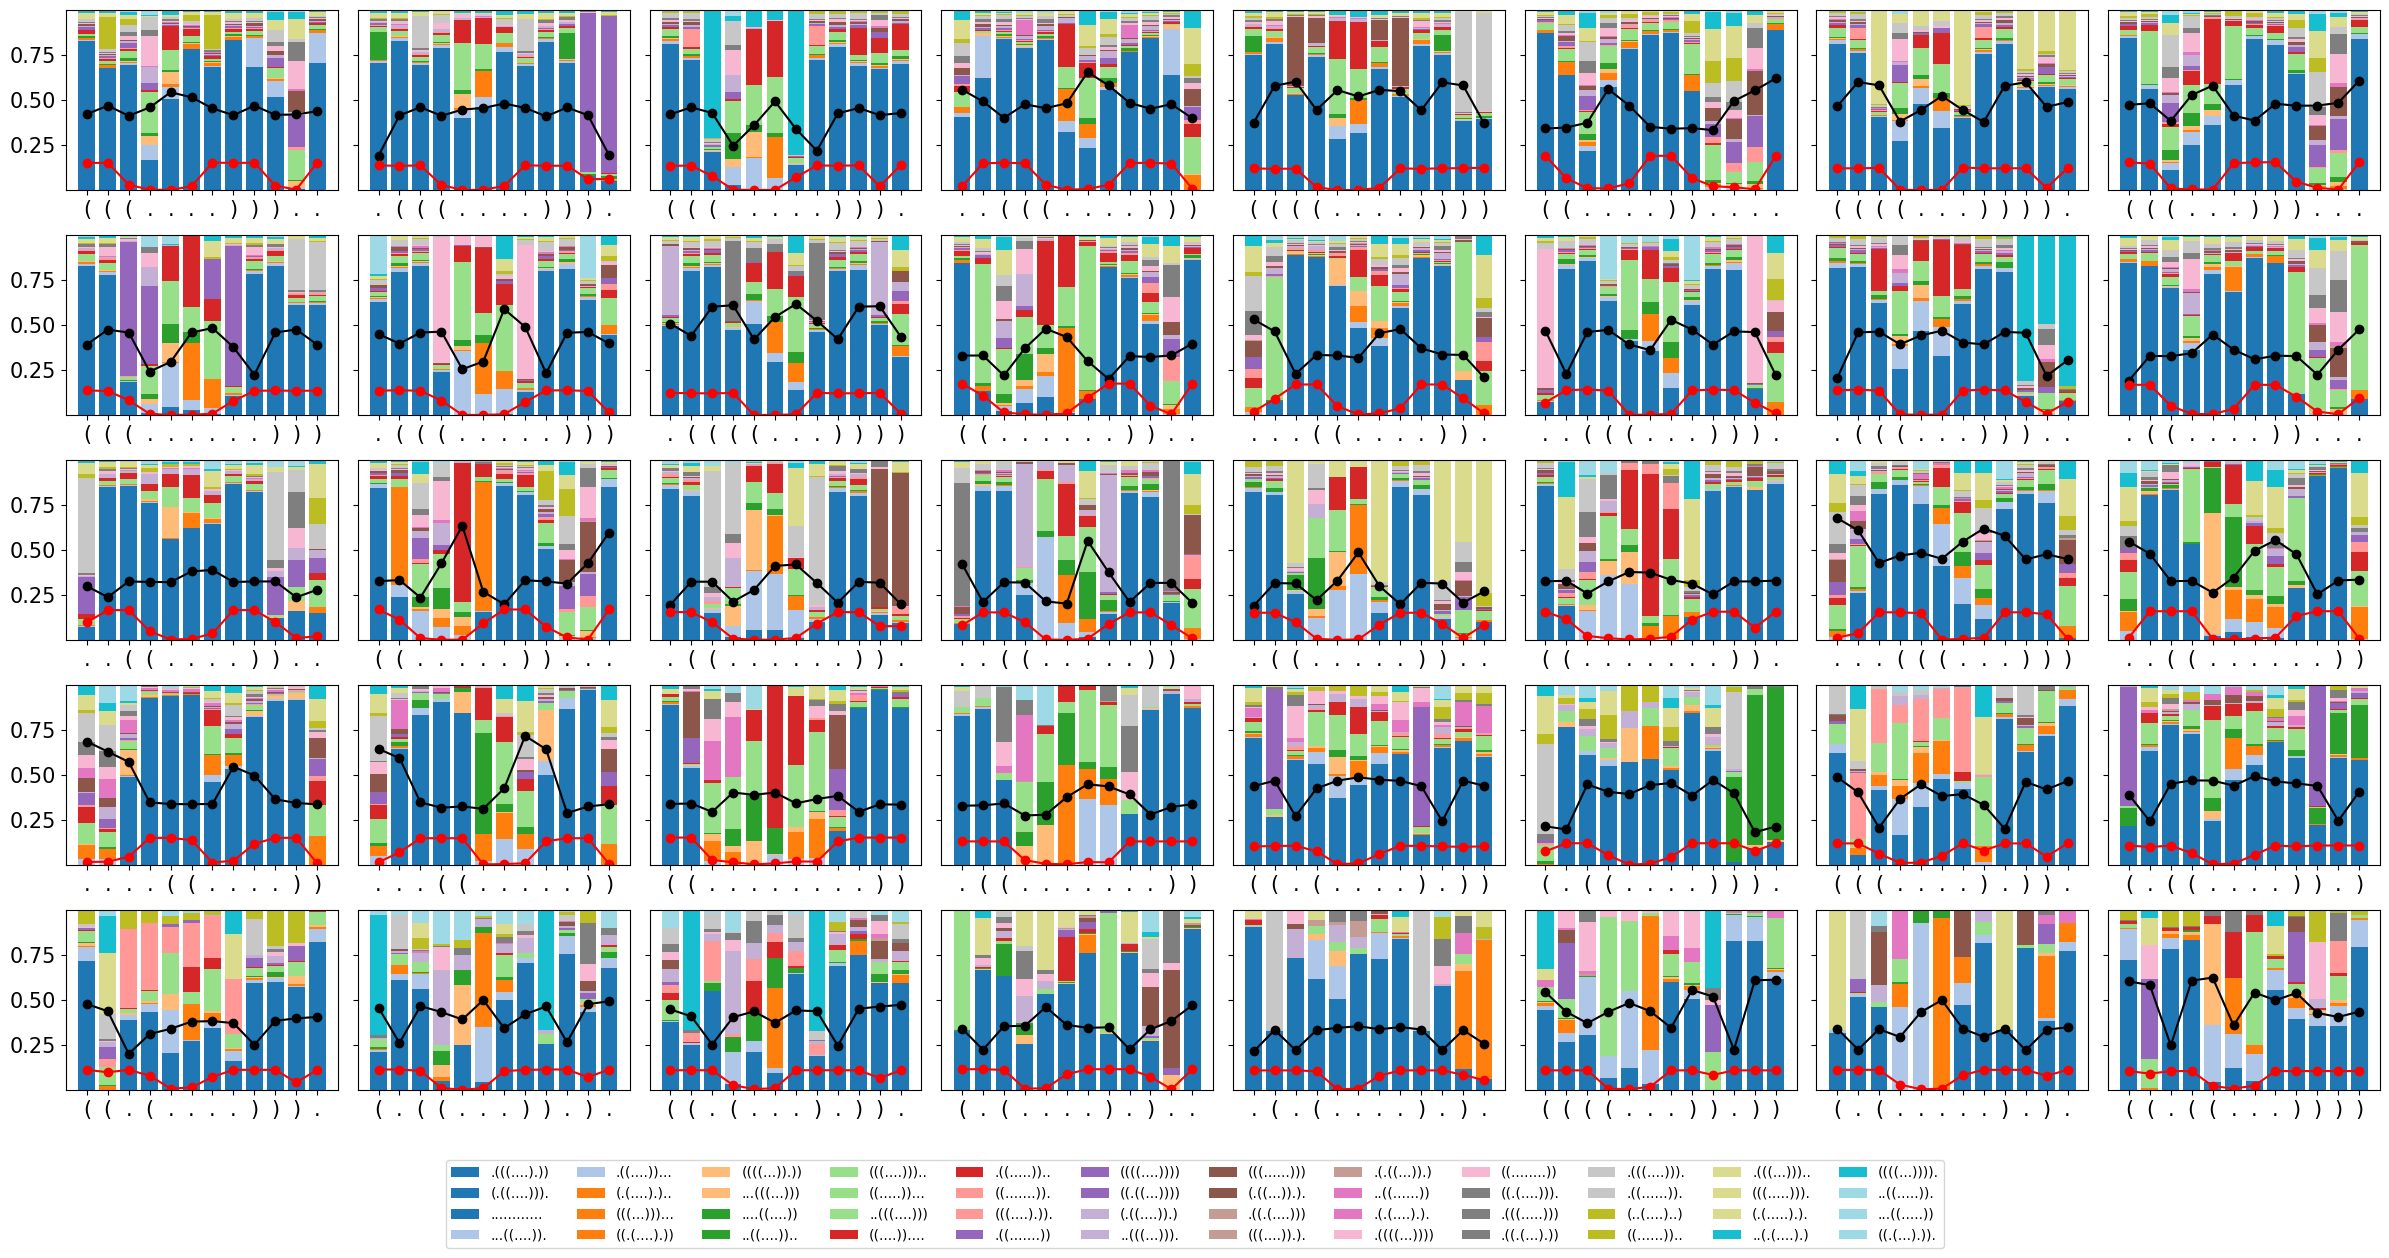

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import functools
import matplotlib.cm as cm

# Example data from phenos_site_set
phenos_site_set = defaultdict(functools.partial(defaultdict, dict))
# Populate phenos_site_set with your data...
for pheno, phenos in phenos_site.items():
    for site, site_phenos in phenos.items():
        phenos_site_set[pheno][site] = dict(Counter(site_phenos)) #take the count of mutations that lead to each phenotype per site
        for phenodict, countphenos in phenos_site_set[pheno][site].items(): #normalize the count by the total number of mutations at that site, this includes going to the deleterious
            phenos_site_set[pheno][site][phenodict] = countphenos / len(site_phenos)

# Prepare the data
L = 12
sites_pos = np.arange(1, L + 1, 1)
phenotypes = set()

# Collect all unique phenotypes
for pheno, sites_dict in phenos_site_set.items():
    for site in sites_dict:
        phenotypes.update(sites_dict[site].keys())

phenotypes = list(phenotypes)

# Create the subplots
fig, axs = plt.subplots(5, 8, figsize=(24, 12), sharey=True)
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 5

# Generate a colormap
colors = cm.get_cmap('tab20', len(phenotypes))

# Collect handles and labels for the legend
handles, labels = [], []

for i, ax in enumerate(axs.flatten()):
    if i < len(phenos_site_set):
        key = list(sort_neutralsets.keys())[i + 1]
        
        sites_dict = phenos_site_set[key]
        
        data = defaultdict(lambda: [0] * len(sites))
        dataevolvability = [0]*L

        sites = list(range(1, 13))

        # Fill the data dictionary with relative areas
        for site in sites_dict:
            for subpheno, value in sites_dict[site].items():
                data[subpheno][site - 1] += value
            dataevolvability[site - 1] = edgeD[key][site]/np.sum(np.array(list(edgeD[key].values()))) 
            #fraction of mutations that go to different phenotypes per site
        # Calculate the bottom positions for stacking
        bottom = np.zeros(len(sites))
        
        # Plot each subpheno with a unique color
        for j, subpheno in enumerate(phenotypes):
            values = data[subpheno]
            bar = ax.bar(sites, values, bottom=bottom, label=subpheno, color=colors(j))
            bottom += values
            if i == 0:  # Collect handles and labels from the first subplot
                handles.append(bar[0])
                labels.append(subpheno)

        # Plot the line plot on top of the bar plot
        sites = [0]*L
        for site, avgs in hamming_local_site[key].items():
            sites[site] = avgs / edgeD[key][site]
        ax.plot(sites_pos, np.array(sites), '-o', color='black')
        ax.plot(sites_pos, np.array(dataevolvability), '-o', color='red')
        ax.set_xticks(sites_pos)  # Set x-ticks to the positions of the sites
        ax.set_xticklabels([key[i] for i in range(L)])  # Label the x-ticks with the corresponding key sites
        ax.tick_params(axis='both', which='major', labelsize=15)  # Set tick label size


# Add a legend for the entire figure at the bottom with two rows
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=(len(phenotypes) + 1) // 4, fontsize=10)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("stacked_bar_plot.png", bbox_inches='tight')
plt.show()

## no deleterious sequence involved in the surface

In [3]:
import pickle
with open("../data/hamming_local_site_nodel.pkl","rb") as f:
    hamming_local_site_nodel = pickle.load(f)
with open("../data/edgeD_nodel.pkl","rb") as f:
    edgeD_nodel = pickle.load(f) #includes deleterious
with open("../data/phenos_site_nodel.pkl","rb") as f:
    phenos_site_nodel = pickle.load(f) #includes deleterious
with open("../data/phenos_site_evol.pkl","rb") as f:
    phenos_site_evol = pickle.load(f)
with open("../data/phenos_site_evol_weight.pkl","rb") as f:
    phenos_site_evol_weight = pickle.load(f)

In [7]:
phenos_site_evol_weight['((((...)))).']

defaultdict(float,
            {0: 830621.6666732073,
             1: 1000268.666671334,
             9: 946995.5000050653,
             10: 874945.0000087803,
             7: 768272.0000040476,
             8: 946177.1666750745,
             2: 872648.5000067125,
             3: 767362.3333373702,
             4: 593253.9999988779,
             5: 542013.1666653653,
             6: 490924.66666390107,
             11: 615743.9999998324})

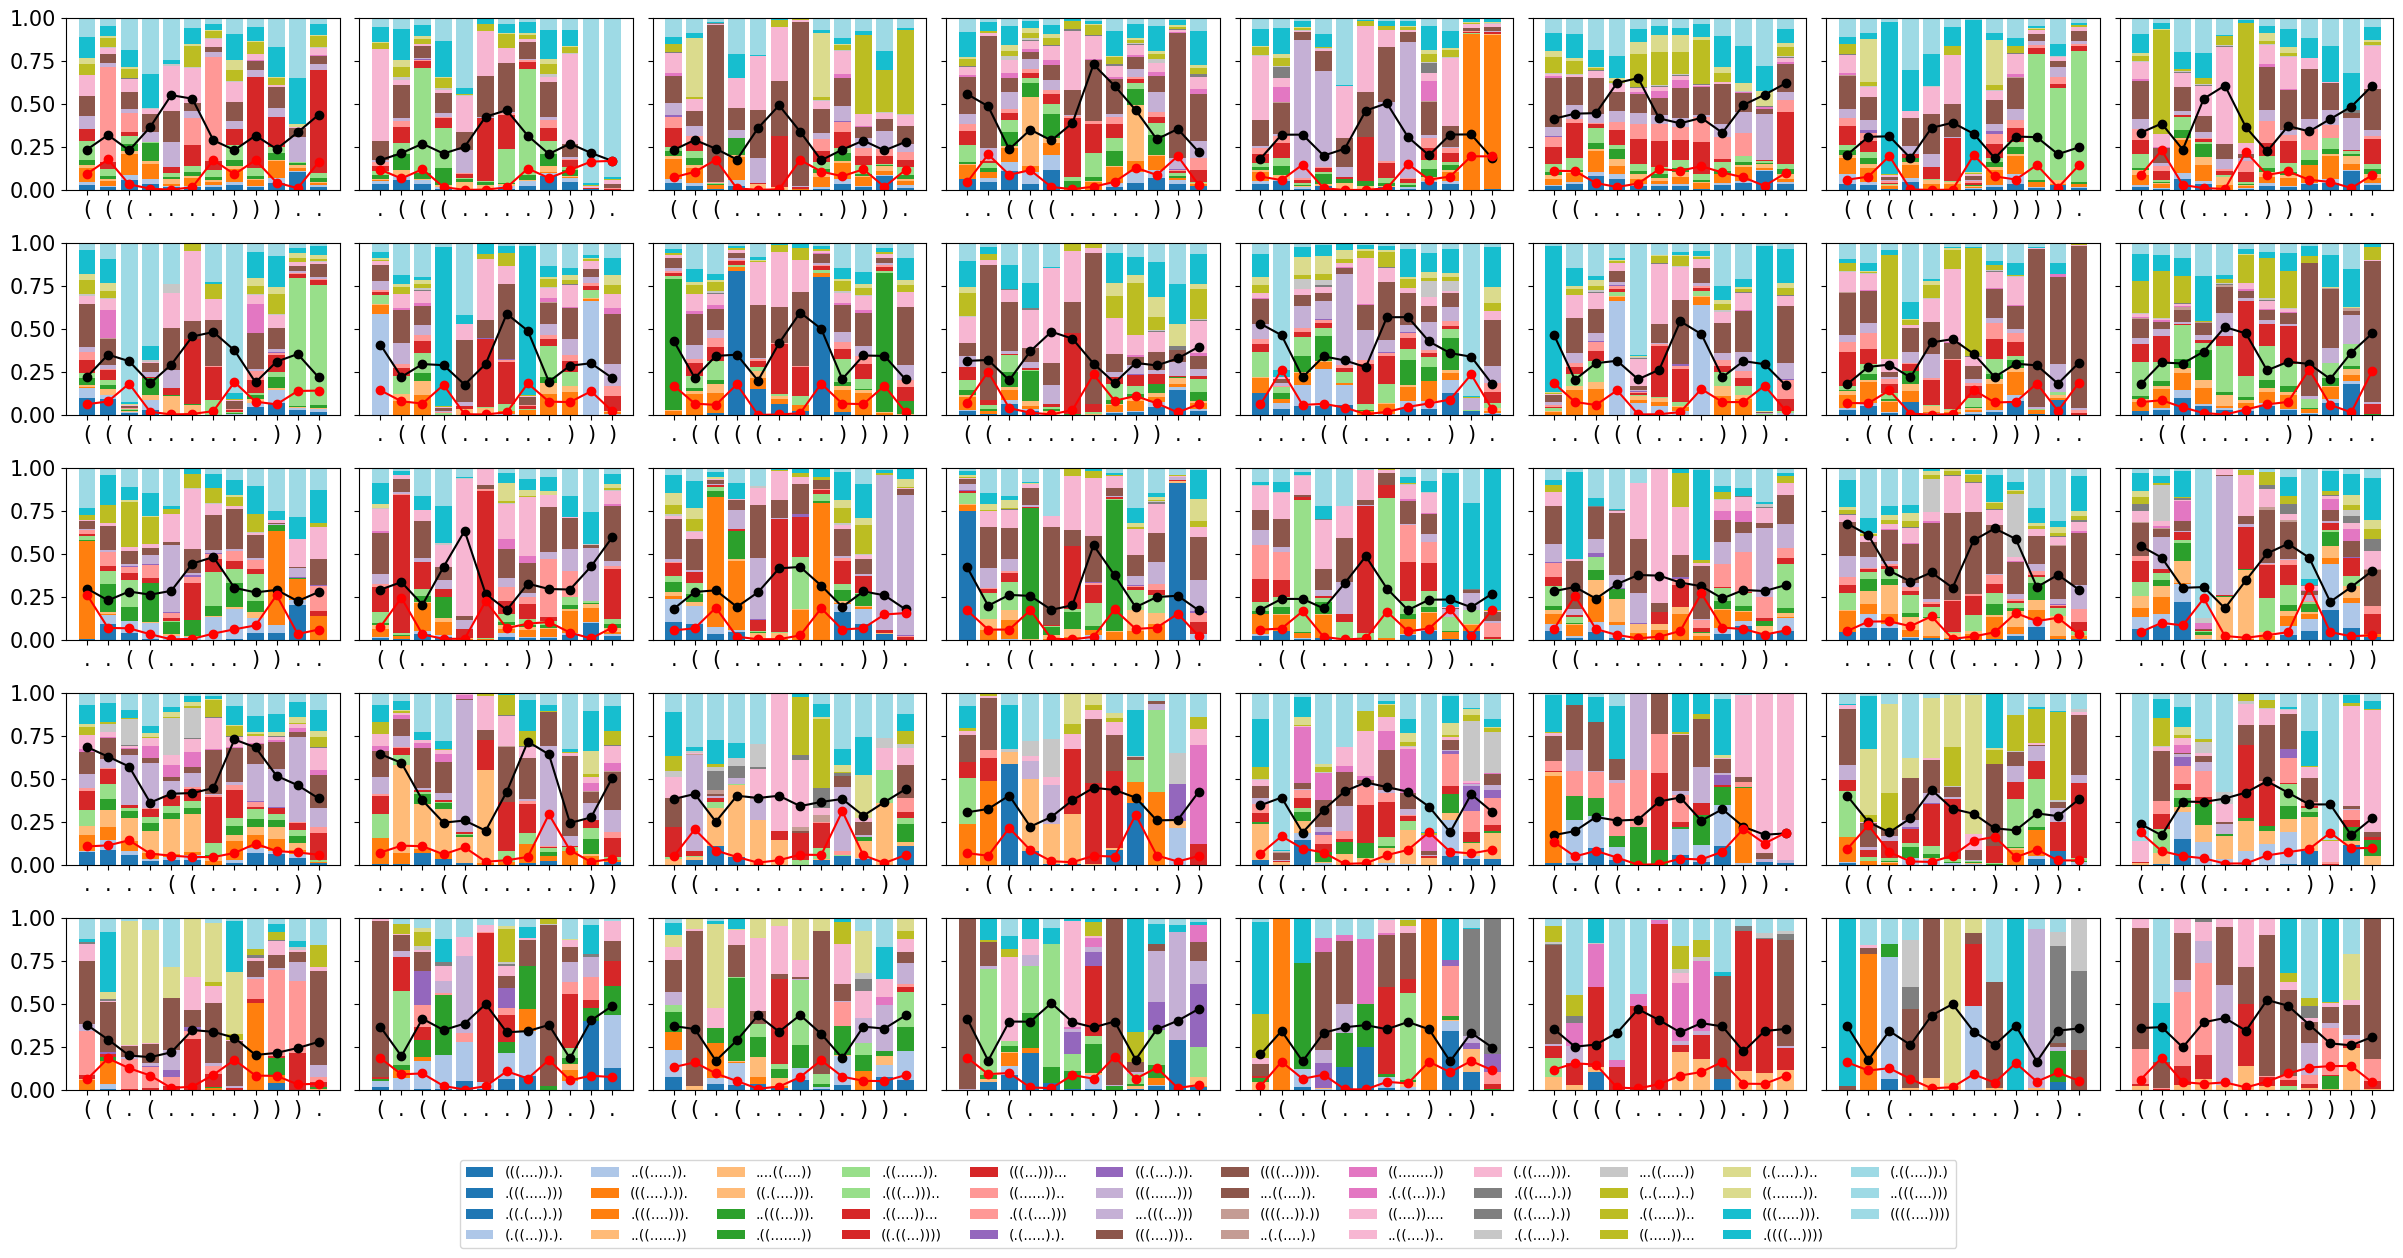

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import functools
import matplotlib.cm as cm

# Example data from phenos_site_set
phenos_site_set = defaultdict(functools.partial(defaultdict, dict))
# Populate phenos_site_set with your data...
for pheno, phenos in phenos_site_nodel.items():
    for site, site_phenos in phenos.items():
        phenos_site_set[pheno][site] = dict(Counter(site_phenos))
        for phenodict, countphenos in phenos_site_set[pheno][site].items(): #normalize the count by the total number of mutations at that site, this includes going to the deleterious
            phenos_site_set[pheno][site][phenodict] = countphenos / len(site_phenos)
# Prepare the data
L = 12
sites_pos = np.arange(1, L + 1, 1)
phenotypes = set()

# Collect all unique phenotypes
for pheno, sites_dict in phenos_site_set.items():
    for site in sites_dict:
        phenotypes.update(sites_dict[site].keys())

phenotypes = list(phenotypes)

# Create the subplots
fig, axs = plt.subplots(5, 8, figsize=(24, 12), sharey=True)
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 5

# Generate a colormap
colors = cm.get_cmap('tab20', len(phenotypes))

# Collect handles and labels for the legend
handles, labels = [], []

for i, ax in enumerate(axs.flatten()):
    if i < len(phenos_site_set):
        key = list(sort_neutralsets.keys())[i + 1]
        
        sites_dict = phenos_site_set[key]
        
        data = defaultdict(lambda: [0] * len(sites))
        dataevolvability = [0]*L

        sites = list(range(1, 13))

        # Fill the data dictionary with relative areas
        for site in sites_dict:
            for subpheno, value in sites_dict[site].items():
                data[subpheno][site - 1] += value

            dataevolvability[site - 1] = phenos_site_evol[key][site]/(len(sort_neutralsets)-1) #fractional evolvability
            #fraction of mutations that go to different phenotypes per site
        # Calculate the bottom positions for stacking
        bottom = np.zeros(len(sites))
        
        # Plot each subpheno with a unique color
        for j, subpheno in enumerate(phenotypes):
            values = data[subpheno]
            bar = ax.bar(sites, values, bottom=bottom, label=subpheno, color=colors(j))
            bottom += values
            if i == 0:  # Collect handles and labels from the first subplot
                handles.append(bar[0])
                labels.append(subpheno)

        # Plot the line plot on top of the bar plot
        sites = [0]*L
        for site, avgs in hamming_local_site_nodel[key].items():
            sites[site] = avgs / edgeD_nodel[key][site]
        ax.plot(sites_pos, np.array(sites), '-o', color='black')
        ax.plot(sites_pos, np.array(dataevolvability), '-o', color='red')
        ax.set_xticks(sites_pos)  # Set x-ticks to the positions of the sites
        ax.set_xticklabels([key[i] for i in range(L)])  # Label the x-ticks with the corresponding key sites
        ax.tick_params(axis='both', which='major', labelsize=15)  # Set tick label size


# Add a legend for the entire figure at the bottom with two rows
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=(len(phenotypes) + 1) // 4, fontsize=10)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("stacked_bar_plot_nodel.png", bbox_inches='tight')
plt.show()